In [ ]:
import os
import pandas as pd
import torch
import os

device = 'cuda'

In [ ]:
torch.cuda.set_per_process_memory_fraction(0.65)

In [ ]:
train_df = pd.read_csv('train_df.tsv', sep = '\t')
from_mark_to_idx = {'Идеально': 2, 'Удовлетворительно': 1, 'Плохо': 0}
train_df['mark'] = train_df['mark'].map(from_mark_to_idx)

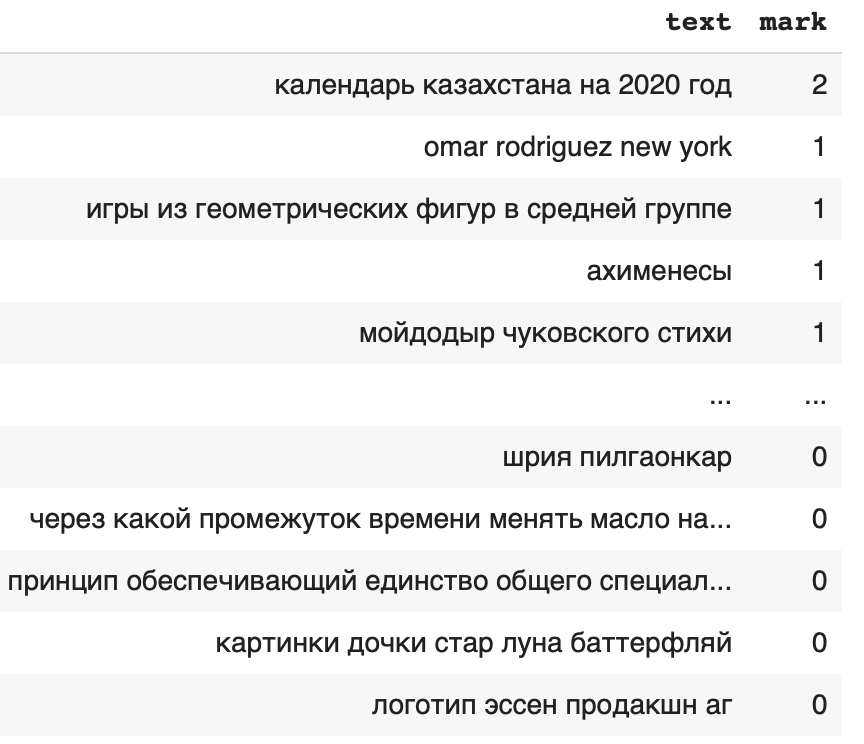

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import re
import torch.nn as nn
from tqdm import tqdm_notebook

In [ ]:
regex_pat = re.compile(r"""[^ А-Яа-яЁёA-Za-z0-9]""")
train_df['text'] = train_df['text'].str.replace(regex_pat, ' ', regex=True)
train_df['text'] = train_df['text'].apply(lambda x: " ".join(x.split()))
train_df['text'] = train_df['text'].str.lower()

25972

In [ ]:
train_df, val_df = train_test_split(train_df, stratify = train_df['mark'],
                                                    test_size=0.33, random_state=42)


In [ ]:
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [ ]:
from torchtext.vocab import vocab
from collections import Counter

/home/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
unk_token = '<unk>'
pad_token = '<pad>'
vocabulary = vocab(Counter(sum(train_df['text'].apply(lambda x: x.split(' ')).tolist(), [unk_token, pad_token])))
vocabulary.set_default_index(vocabulary[unk_token])

In [ ]:
vocabulary[pad_token]

1

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
import torchvision

RESNET_trasforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(
        size=(224, 224)
    ),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



class Classify_dataset(Dataset):
    def __init__(self, dataframe, transforms = None):
        self.df = dataframe
        self.df = self.df.reset_index(drop = True)
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        vals = self.df.iloc[idx]
        im_name = vals['filename']
        image = np.array(Image.open(im_name))
        text = vals['text']
        label = vals['mark']
        if self.transforms:
            image = self.transforms(image)
        return {'image' : image, 'text' : text, 'label' : label}


In [ ]:
train_dataset = Classify_dataset(train_df, RESNET_trasforms)
val_dataset = Classify_dataset(train_df, RESNET_trasforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=False, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=False)

In [ ]:
device = 'cuda'

In [ ]:
class Mean(nn.Module):
    def __init__(self, text_vocab, emb):
        super(Mean, self).__init__()
        self.text_vocab = text_vocab
        self.emb = emb

    def forward(self, x):
        embeddings = self.emb(x)
        mask = x!=self.text_vocab[pad_token]
        denom = torch.sum(mask, -1, keepdim=True)
        embeddings = torch.sum(embeddings * mask.unsqueeze(-1), dim=1) / denom
        return embeddings

class Classifier(nn.Module):
    def __init__(self, text_vocab):
        super(Classifier, self).__init__()
        self.im_encoder = models.resnet50(pretrained=True)
        self.im_encoder.fc = torch.nn.Linear(in_features=2048, out_features=512)
        self.emb = nn.Embedding(len(text_vocab), 256, padding_idx = text_vocab[pad_token])
        self.text_vocab = text_vocab
        self.text_encoder = self.create_text_encoder()
        self.head = self.create_head()



    def create_text_encoder(self):
        seq = torch.nn.Sequential(
            Mean(self.text_vocab, self.emb),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            torch.nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        return seq

    def create_head(self):
        seq = torch.nn.Sequential(
            torch.nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            torch.nn.Linear(in_features=256, out_features=3),
        )
        return seq

    def forward(self, x):
        im, text = x
        im = self.im_encoder(im)
        text = self.text_encoder(text)
        val = torch.add(im, text)
        val = self.head(val)
        return val





In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor


class PlModel(pl.LightningModule):
    def __init__(self, learning_rate, vocabulary):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = Classifier(vocabulary)
        self.vocabulary = vocabulary
        self.criterion = nn.CrossEntropyLoss()

    def align_tokens(self, texts):
        max_len = len(max(texts, key = lambda x: len(x)))
        for i in range(len(texts)):
            texts[i] += [self.vocabulary[pad_token] for i in range(max_len - len(texts[i]))]
        return texts

    def training_step(self, batch, batch_idx):
        images = batch['image'].to(device)
        texts = batch['text']
        labels = batch['label']
        texts = [self.vocabulary(text.split(' ')) for text in texts]
        texts = self.align_tokens(texts)
        texts = torch.tensor(texts, dtype=torch.long).to(device)
        preds = self.model((images, texts))

        loss = self.criterion(preds, labels)
        self.log("train_loss", loss)
        self.log('step', self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image'].to(device)
        texts = batch['text']
        labels = batch['label']
        texts = [self.vocabulary(text.split(' ')) for text in texts]
        texts = self.align_tokens(texts)
        texts = torch.tensor(texts, dtype=torch.long).to(device)
        preds = self.model((images, texts))
        loss = self.criterion(preds, labels)

        self.log("validation_loss", loss, sync_dist=True)
        preds = torch.argmax(preds, dim = 1)
        self.log("validation_accuracy", torch.sum(labels == preds)/labels.shape[0], sync_dist=True)

    def forward(self, images):
        preds = self.model(images)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        def func(epoch: int):
            return  2 ** (-epoch//4)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=func)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }

In [ ]:
model = PlModel(1e-3, vocabulary)

In [ ]:
# model
pl_model = PlModel(1e-3, vocabulary)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=5)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(auto_lr_find = True, max_epochs = 100,
                     accelerator="cuda", devices=7,#[0],
                     callbacks=[early_stopping, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
lr_finder = trainer.tuner.lr_find(pl_model, train_loader)
pl_model.hparams.learning_rate = lr_finder.suggestion()
print(f'Auto-find model LR: {pl_model.hparams.learning_rate}')

fig = lr_finder.plot(suggest=True)

In [ ]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/7
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/7
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/7
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/7
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/7
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/7
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/7
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 7 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 6 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 4 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5

Sanity Checking: 0it [00:00, ?it/s]

/home/.local/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:209: UserWarning: num_workers>0, persistent_workers=False, and strategy=ddp_spawn may result in data loading bottlenecks. Consider setting persistent_workers=True (this is a limitation of Python .spawn() and PyTorch)
  "num_workers>0, persistent_workers=False, and strategy=ddp_spawn"
/home/.local/lib/python3.7/site-packages/lightning/pytorch/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/home/.local/lib/python3.7/site-packages/lightning/pytorch/trainer/trainer.py:1613: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs

Training: 0it [00:00, ?it/s]

[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1303] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

/home/.local/lib/python3.7/site-packages/lightning/pytorch/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 54. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
device = 'cuda'
model = Classifier(vocabulary)
model.load_state_dict(torch.load('kek.ckpt'))
model.eval()
model.to(device)
1

1

In [ ]:
test_df = pd.read_csv('test_df.tsv', sep = '\t')

In [ ]:
test_df

,filename,text,mark
0,competition_data:171038.png,скачать бесплатно картинки доброе утро,Идеально
1,competition_data:359121.png,эстетичные тетради блокноты и т д,Плохо
2,competition_data:447.png,ауди rs7 радмир,Удовлетворительно
3,competition_data:245862.png,матрешка русская народная игрушка,Удовлетворительно
4,competition_data:28865.png,монхетен утром,Плохо
...,...,...,...
11995,competition_data:102361.png,кызылорда жаналыктары сонгы,Идеально
11996,competition_data:164750.png,серьги из серебра с розовым кварцем,Идеально
11997,competition_data:103748.png,arcctg0,Удовлетворительно
11998,competition_data:183162.png,мастер и маргарита книга картинка,Удовлетворительно


In [ ]:
test_df['mark'] = test_df['mark'].map(from_mark_to_idx)

In [ ]:
regex_pat = re.compile(r"""[^ А-Яа-яЁёA-Za-z0-9]""")
test_df['text'] = test_df['text'].str.replace(regex_pat, ' ', regex=True)
test_df['text'] = test_df['text'].apply(lambda x: " ".join(x.split()))
test_df['text'] = test_df['text'].str.lower()

12000

In [ ]:
last_model = model

In [ ]:
test_dataset = Classify_dataset(test_df, RESNET_trasforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=False)

In [ ]:
all_preds = []
all_gt = []
for batch in tqdm_notebook(test_loader):
    images = batch['image'].to(device)
    texts = batch['text']
    labels = batch['label']
    texts = [vocabulary(text.split(' ')) for text in texts]
    texts = pl_model.align_tokens(texts)
    texts = torch.tensor(texts, dtype=torch.long).to(device)
    with torch.no_grad():
        preds = last_model((images, texts))
    preds = torch.argmax(preds, dim = 1)
    all_preds.append(preds.cpu().detach().numpy())
    all_gt.append(labels.numpy())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
preds = np.hstack(all_preds)
gt = np.hstack(all_gt)

In [ ]:
np.sum(gt==preds)/preds.shape[0]

0.5195

# RUCLIP

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import re
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm_notebook

train_df = pd.read_csv('train_df.tsv', sep = '\t')
train_df['filename'] = '/train/' + train_df['filename']
from_mark_to_idx = {'Идеально': 2, 'Удовлетворительно': 1, 'Плохо': 0}
train_df['mark'] = train_df['mark'].map(from_mark_to_idx)
regex_pat = re.compile(r"""[^ А-Яа-яЁёA-Za-z0-9]""")
train_df['text'] = train_df['text'].str.replace(regex_pat, ' ', regex=True)
train_df['text'] = train_df['text'].apply(lambda x: " ".join(x.split()))
train_df['text'] = train_df['text'].str.lower()
train_df['filename'].nunique()
train_df, val_df = train_test_split(train_df, stratify = train_df['mark'],
                                                    test_size=0.33, random_state=42)
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [ ]:
import ruclip

def get_ruclip_model(args):
    device = args.device
    model, processor = ruclip.load(args.pretrained, device=device)
    def im_preprocess(image):
        return processor(text='', images=[image], return_tensors='pt', padding=True)['pixel_values'][0]
    def text_preprocess(text):
        if isinstance(text, str):
            return processor(text=text, return_tensors='pt', padding=True)['input_ids'][0]
        else:
            all_vals = []
            for i in text:
                all_vals.append(torch.Tensor(np.array(processor(text=i, return_tensors='pt', padding=True)['input_ids'][0])).reshape(1, -1).to(torch.long))
            return torch.cat(all_vals, dim = 0)
    model.to(device)
    preprocessor = im_preprocess
    tokenizer = text_preprocess
    return model, tokenizer, preprocessor

In [ ]:
class Params:
    device = 'cuda'
    pretrained = 'ruclip-vit-base-patch32-224'
args = Params()

In [ ]:
model, tokenizer, preprocessor = get_ruclip_model(args)

/home/.local/lib/python3.7/site-packages/huggingface_hub/file_download.py:654: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:18: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [ ]:
model.to(device)
1

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
import torchvision

class Ruclip_Classify_dataset(Dataset):
    def __init__(self, dataframe, transforms = None, tokenizer = None):
        self.df = dataframe
        self.df = self.df.reset_index(drop = True)
        self.transforms = transforms
        self.tokenizer = tokenizer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        vals = self.df.iloc[idx]
        im_name = vals['filename']
        image = Image.open(im_name)
        text = vals['text']
        label = vals['mark']
        if self.transforms:
            image = self.transforms(image)
        if self.tokenizer:
            text = self.tokenizer(text)
        return {'image' : image, 'text' : text, 'label' : label}


In [ ]:
train_dataset = Ruclip_Classify_dataset(train_df, preprocessor, tokenizer)
val_dataset = Ruclip_Classify_dataset(val_df, preprocessor, tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=False, drop_last = False)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=False)

In [ ]:
def get_scores(loader):
    scores = []
    for batch in tqdm_notebook(loader):
        batch_images = batch['image'].to(device)
        batch_texts_tok = batch['text'].to(device)
        with torch.no_grad():
            batch_images_emb = F.normalize(model.encode_image(batch_images), dim=-1)
            batch_texts_emb = F.normalize(model.encode_text(batch_texts_tok), dim=-1)
        scores.append(torch.diagonal(batch_images_emb@batch_texts_emb.T).cpu().detach().numpy())

    return np.hstack(scores)

In [ ]:
train_scores = get_scores(train_loader)
valid_scores = get_scores(valid_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

In [ ]:
train_df['scores'] = train_scores
val_df['scores'] = valid_scores

In [ ]:
def put_vals(df, best, good, bad):
    preds = np.zeros(df.shape[0])
    for i in best:
        preds[i] = 2
    for i in good:
        preds[i] = 1
    for i in bad:
        preds[i] = 0
    return preds

best_acc = -1

for left_border in tqdm_notebook(np.linspace(0, 1, 51)):
    for right_border in np.linspace(0, 1, 51):
        best_vals = list(train_df[train_df['scores']>=right_border].index)
        good_vals = list(train_df[(train_df['scores']<right_border)&(train_df['scores']>left_border)].index)
        bad_vals = list(train_df[train_df['scores']<=left_border].index)
        train_preds = put_vals(train_df, best_vals, good_vals, bad_vals)
        accuracy = np.sum(train_df['mark'].values==train_preds)/train_df['mark'].shape[0]
        if accuracy > best_acc:
            best_left_border = left_border
            best_right_border = right_border
            best_acc = accuracy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
best_acc

0.4654904890523533

In [ ]:
best_left_border

0.0

In [ ]:
best_right_border

1.0

In [ ]:
best_vals = list(val_df[val_df['scores']>=right_border].index)
good_vals = list(val_df[(val_df['scores']<right_border)&(val_df['scores']>left_border)].index)
bad_vals = list(val_df[val_df['scores']<=left_border].index)
val_preds = put_vals(val_df, best_vals, good_vals, bad_vals)

In [ ]:
accuracy = np.sum(val_df['mark'].values==val_preds)/val_df['mark'].shape[0]

In [ ]:
accuracy

0.07700385019250963